In [14]:
!pip install pypdf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 9.9 MB/s eta 0:00:00


In [17]:
import numpy
import pandas
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import io

# for tokenizers and reading pdf
from transformers import AutoTokenizer, AutoModel
import torch
#import fitz  # PyMuPDF
import pypdf

# Display the variable in Markdown format
from IPython.display import Markdown, display

# for api
import requests
import json

# to calculate similarities
from sklearn.metrics.pairwise import cosine_similarity


In [ ]:
class pdf_processing:
  def __init__(self, path, chunk_size):
    self.path = path
    self.chunk_size = chunk_size
    # saves all text in one var and other saves the text page wise
    self.text, self.text_p = "", []
    self.chunks = []

  def extract_text(self):
    # extract text
    """with fitz.open(self.path) as pdf:
        for page in pdf:
            self.text_p.append(page.get_text())
            self.text += page.get_text()
    return self.text_p, self.text"""

    # pypdf2 works well with some other forms of pdfs as well
    with open(self.path, 'rb') as file:
        reader = PyPDF2.PdfReader(file)
        pages = reader.pages
        total_pages = len(pages)

        for i in range(total_pages):
            textn = pages[i].extract_text()
            self.text_p.append(textn)
            self.text += textn

    return self.text_p, self.text

  def create_chunks(self):
    # create chunks
    for i in range(0, len(self.text), self.chunk_size):
        new_chunk = self.text[i : i + self.chunk_size].lower()
        self.chunks.append(new_chunk)
    return self.chunks


def generate_embeddings(chunks):
    embeddings = []

    # Load model and tokenizer
    model_name = "sentence-transformers/all-MiniLM-L6-v2"

    # define tokenizer, pre trained tokenizer are used to avoid unknown tokens, also good for domain adaption where tokenizer will
    # be used for specific application
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # define model
    model = AutoModel.from_pretrained(model_name)

    for chunk in chunks:
        inputs = tokenizer(chunk, return_tensors = 'pt', truncation = True, padding = True)
        #print("inputs : ", inputs)
        """
        The tokenizer processes the text chunk and converts it into a format suitable for the model.
        # args...

        return_tensors='pt': This argument specifies that the output should be in PyTorch tensor format, which is required for the model.
        truncation=True: This ensures that any input longer than the model's maximum length is truncated, preventing errors during processing.
        padding=True: This ensures that shorter inputs are padded to the same length, allowing for batch processing.

        # keys that are returned and which will be used as arg to model:
        input_ids : list of token ids of all tokenised words
        attention_mask : binary mask indicating which tokes are to be attended by the model
        token_type_ids :  It indicates which tokens belong to which segment, if all tokens belong to a single segment then [0,0,0,0]
        overflowing_tokens : This key contains any tokens that were truncated when the input exceeded the maximum length allowed by the model.
        num_truncated_tokens : number of truncated tokesm
        """
        with torch.no_grad():
            outputs = model(**inputs)
            """
            No Gradient Calculation: The with torch.no_grad(): context manager is used to disable gradient calculations. This is important during inference to save memory
            and speed up computations since we don't need gradients for backpropagation.
            Model Output: The model processes the tokenized inputs and returns the outputs, which include various hidden states.
            The **inputs syntax unpacks the dictionary of input tensors into keyword arguments(as described earlier) for the model.
            """

            k = outputs.last_hidden_state
            #print("meaned last hidden layer : ", k.shape) # prints mean of all multidimensional layers
            embeddings.append(k.mean(dim=1).squeeze().numpy())
            # last hidden state is output of last layer
            """
            Extracting Last Hidden State:
            outputs.last_hidden_state contains the hidden states for all tokens in the input sequence. This is a tensor of shape (batch_size, sequence_length, hidden_size).
            Mean Calculation:
            mean(dim=1) computes the mean of the hidden states across all tokens in the sequence, effectively creating a single embedding for the entire input chunk.
            This is done to obtain a fixed-size vector representation for each chunk.
            Squeeze and Convert to NumPy:
            """
    return embeddings

def search(query, embeddings, chunks):
  query_embedding = generate_embeddings([query])[0]
  similarities = cosine_similarity([query_embedding], embeddings)
  best_match_index = similarities.argsort()[0, ::-1]
  return "\n".join([chunks[best_match_index[x]] for x in range(5)])


In [ ]:
class LLM:
  def __init__(self):
    self.key = ""

    self.url = f'https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash-latest:generateContent?key={self.key}'
    self.headers = {'Content-Type': 'application/json'}

  def _prompt_dic(self, prompt):
    return {
              "contents": [
                  {
                      "parts": [
                          {
                              "text": prompt
                          }
                      ]
                  }
              ],

              "generationConfig": {
                  "temperature": 0.7,
                  "topK": 40,
                  "topP": 0.95,
                  "maxOutputTokens": 1024,
              }
            }

  def generate_rag(self, query):
    prompt = f"""
                            You are an AI assistant capable of processing large documents and providing detailed, structured responses.
                            Your task is to analyze the user query and guide a retrieval system to fetch relevant information from a knowledge base or document repository.

                            Here’s the workflow:
                            1. I will provide you with a query or a goal.
                            2. Analyze the query and list the key information, topics, or concepts that should be retrieved to answer it.

                            ### Input Query:
                            {query}

                            ### Your Output:
                            1. Identify key information or topics relevant to the query.
                            2. Suggest search terms or filters to retrieve the most relevant content.
                            3. Highlight the structure or format you expect in the retrieval results to answer the query effectively.
                            """

    response = requests.post(self.url, headers = self.headers, json = self._prompt_dic(prompt))
    r = response.json()
    return r['candidates'][0]['content']['parts'][0]['text']

  def generate_final_response(self, query):

    prompt = f"""Here is the retrieved information based on your earlier suggestions. Refine your response by integrating this data to provide a complete answer to the query.

                ### Original Query:
                {query}

                ### Retrieved Information:
                {rag_response}

                ### Your Task:
                1. Synthesize the retrieved data into a coherent, detailed response.
                2. If necessary, identify gaps in the information and suggest additional topics or search terms for retrieval.
                3. Present the final response in a user-friendly format, highlighting key points and providing structured details if required.

              """

    response = requests.post(self.url, headers = self.headers, json = self._prompt_dic(prompt))
    r = response.json()
    print(Markdown(r['candidates'][0]['content']['parts'][0]['text']))


## main


In [ ]:
obj = pdf_processing("/content/Python_Data_Science_Handbook.pdf", 1000)
page_text, text = obj.extract_text()
chunks = obj.create_chunks()
#embeddings = generate_embeddings(chunked)

In [ ]:
def example_usage(pages):
    # Example usage of the extractor
    extractor = BookMetadataExtractor()
    metadata = extractor.process_book(pages)
    return metadata

metadata = example_usage(page_text)

In [ ]:
with open("/content/Python_Data_Science_Handbook.pdf", 'rb') as file:
    reader = PyPDF2.PdfReader(file)
    pages = reader.pages
    total_pages = len(pages)
    page = []
    for i in range(total_pages):
        page.append(pages[i].extract_text())


In [ ]:
page[5]

'Passing Values to and from the Shell                                                                         18\nShell-Related Magic Commands                                                                                   19\nErrors and Debugging                                                                                                     20\nControlling Exceptions: %xmode                                                                              20\nDebugging: When Reading Tracebacks Is Not Enough                                          22\nProfiling and Timing Code                                                                                             25\nTiming Code Snippets: %timeit and %time                                                             25\nProfiling Full Scripts: %prun                                                                                      27\nLine-by-Line Profiling with %lprun                                                             

In [ ]:
metadata.keys()

dict_keys(['chapters', 'page_numbers', 'index'])

In [ ]:
page_text

[]

In [ ]:
print(text[60000:70000])

tax when I run ex1.py.
You are probably trying to run Python, then trying to type Python again. Close your Terminal, start 
it again, and right away type only python ex1.py.
I get can't open file 'ex1.py': [Errno 2] No such file or directory.
You need to be in the same directory as the ﬁ le you created. Make sure you use the cd command to 
go there ﬁ rst. For example, if you saved your ﬁ le in lpthw/ex1.py, then you would do cd lpthw/ 
before trying to run python ex1.py. If you don’t know what any of that means, then go through 
the Command Line Crash Course (CLI- CC) mentioned in the ﬁ rst question.
How do I get my country’s language characters into my ﬁ le?
Make sure you type this at the top of your ﬁ le: # - *-  coding: utf- 8 - *- .
My ﬁ le doesn’t run; I just get the prompt back with no output.
You most likely took the previous code literally and thought that print "Hello World!" meant 
to literally print just "Hello World!" into the ﬁ le, without the print. Your ﬁ le has to be ex

In [ ]:
query = "commmon student questions on Names, Variables, Code, Functions".lower()

In [ ]:
llm = LLM()

In [ ]:
enhanced_query = llm.generate_rag(query)

In [ ]:
Markdown(enhanced_query)

1. **Key Information/Topics:**

* **Naming conventions:**  This includes rules and best practices for naming variables, functions, and other code elements (e.g., camelCase, snake_case, PascalCase, meaningful names, avoiding reserved keywords).  This also encompasses the scope of names (local vs. global).
* **Variable types and declaration:**  This covers the different data types supported by programming languages (integers, floats, strings, booleans, etc.), how variables are declared and initialized, and type casting or conversion.
* **Code structure and organization:** This includes concepts like code blocks, indentation, comments, and how these contribute to readability and maintainability.  It may also touch upon the organization of larger code projects (modules, packages).
* **Function definition and usage:** This covers how to define functions, including parameters, return types, and function calls.  It also includes concepts like function scope, recursion, and passing arguments (by value vs. by reference).
* **Common errors related to names, variables, and functions:** This includes issues like naming conflicts, type errors, scope issues, and common syntax mistakes.

2. **Search Terms/Filters:**

* **Broad terms:**  "programming fundamentals," "variable declaration," "function definition," "naming conventions," "code style," "common programming errors"
* **Specific language filters:**  If the query is for a specific language (e.g., Python, Java, C++), include that language as a filter (e.g., "Python variable types," "Java function overloading").
* **Error-specific filters:**  "undefined variable error," "type mismatch error," "name conflict error," "syntax error in function definition"
* **Platform/Tutorial filters:** If the target audience is specific (e.g., beginners using a particular online learning platform), include that platform in the search.


3. **Expected Structure/Format of Retrieval Results:**

The ideal retrieval results would be structured as a series of concise explanations and examples for each key topic identified above.  A good format might be:

* **Topic:** (e.g., Variable Naming Conventions)
    * **Explanation:** (Clear and concise definition with examples)
    * **Example:** (Code snippets illustrating correct and incorrect usage)
    * **Common Errors:** (Brief description of potential problems and how to avoid them)
    * **Further Reading:** (Links to more detailed resources if applicable)

This structured approach would allow for easy compilation into a comprehensive FAQ-style answer addressing common student questions on the specified topics.  The results should cater to varying levels of understanding, from beginner to intermediate.  Including visual aids (like diagrams or flowcharts) where appropriate would enhance understanding.


In [ ]:
rag_response = search(query, embeddings, chunked)
rag_response

"e function name?\n \n4. \ndid you put your arguments after the parenthesis ( separated by commas?\n \n5. \ndid you make each argument unique (meaning no duplicated names)?\n \n6. \ndid you put a close parenthesis and a colon ): after the arguments?\n \n7. \ndid you indent all lines of code you want in the function four spaces? no more, no less.\n \n8. \ndid you “end” your function by going back to writing with no indent (dedenting we call it)?\nand when you run (“use” or “call”) a function, check these things:\n \n1. \ndid you call/use/run this function by typing its name?\n \n2. \ndid you put the ( character after the name to run it?\n \n3. \ndid you put the values you want into the parenthesis separated by commas?\n \n4. \ndid you end the function call with a ) character?\nuse these two checklists on the remaining lessons until you do not need them anymore. finally, \nrepeat this a few times: “to ‘run,’ ‘call,’ or ‘use’ a function all mean the same thing.”\ncommon student questions\

In [45]:
import fitz
import io
from PIL import Image

images = {}

with fitz.open(pdf_path) as fitz_pdf:
    for page_num, page in enumerate(fitz_pdf):
        print(f"Processing Page {page_num + 1}")

        # First get the raw image list
        image_list = page.get_images()
        if image_list:
            print(f"Page {page_num + 1} contains {len(image_list)} image(s).")

            # Get locations of images on page
            img_info_list = page.get_image_info()

            # Extract text blocks with their bounding boxes
            text_blocks = page.get_text("words")

            # Process each image
            for img_index, img in enumerate(image_list):
                # Get the image location from img_info_list
                img_info = img_info_list[img_index]
                image_bbox = img_info['bbox']
                print(f"Image bounding box: {image_bbox}")

                # Extract the raw image data
                base_image = fitz_pdf.extract_image(img[0])
                image_bytes = base_image["image"]

                # Find description text below image
                descr = ""
                for block in text_blocks:
                    if block[1] > image_bbox[3] and block[1] < image_bbox[3] + 20:
                        descr += " " + block[4]

                # Convert to PIL Image while maintaining original quality
                images[descr] = Image.open(io.BytesIO(image_bytes))

Processing Page 1
Page 1 contains 2 image(s).
Image bounding box: (-1.8661575317382812, 71.3619384765625, 556.898681640625, 569.0682983398438)
Image bounding box: (-1.8661575317382812, 71.3619384765625, 556.898681640625, 569.0682983398438)
Processing Page 2
Page 2 contains 1 image(s).
Image bounding box: (0.0, 0.0, 504.0, 661.5)
Processing Page 3
Processing Page 4
Processing Page 5
Processing Page 6
Processing Page 7
Processing Page 8
Processing Page 9
Processing Page 10
Processing Page 11
Processing Page 12
Processing Page 13
Page 13 contains 1 image(s).
Image bounding box: (178.08975219726562, 408.18310546875, 326.4102478027344, 544.0235595703125)
Processing Page 14
Processing Page 15
Processing Page 16
Processing Page 17
Page 17 contains 1 image(s).
Image bounding box: (72.0, 550.4171142578125, 162.0, 580.5819702148438)
Processing Page 18
Processing Page 19
Processing Page 20
Processing Page 21
Processing Page 22
Processing Page 23
Processing Page 24
Processing Page 25
Processing Pa

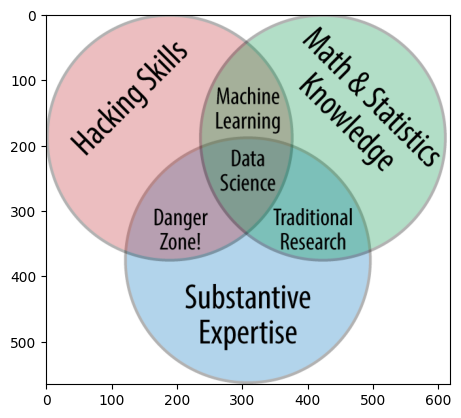

In [47]:
plt.imshow(images[" Figure P-1. Drew Conway’s Data Science Venn Diagram"])

Cloning into 'RAGBOT'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (3/3), done.
/content/RAGBOT/RAGBOT/RAGBOT
fatal: /content/prj1.ipynb: '/content/prj1.ipynb' is outside repository at '/content/RAGBOT/RAGBOT/RAGBOT'
On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean
fatal: could not read Username for 'https://github.com': No such device or address
